# Testing out Long-Short Term Memory with PyTorch

Generating sequential data from a simplified Kalman filter and then trying to predict the next observation using LSTM

Data Generation proccess will yield a timeseries data for a simplified kalman filter

Simplified Kalman filter:
    $X_{t+1}=A*X_{t}+\epsilon_{1,t+1} \space \space  \space Y_{t+1}=B*X_{t+1}+\epsilon_{2,t+1}$

$X_{t}$ is the state vector and $Y_{t}$ is the observation


$\epsilon_{1}$ is the process noise and $\epsilon_{2}$ is the observation noise. let them both be normally distributed with mean zero with their appropriate standard deviations $\sigma_{1}$ and $\sigma_{2}$:

$\sigma_{1}=0.01 , \sigma_{2}=0.2$

Matrices A and B are given by:

$$A= \begin{bmatrix} \frac{\sqrt(99)}{10} & -\frac{1}{10}  \\ \frac{1}{10} & \frac{\sqrt99}{10} \end{bmatrix}$$

$$B= \begin{bmatrix} \frac{\sqrt2}{2} & -1  \\ \frac{\sqrt2}{2} & \frac{\sqrt2}{2} \end{bmatrix}$$


Now I can generate the data:

In [1]:
import numpy as np
from math import sqrt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
epsilon1=np.random.normal(0,0.01,2000)
epsilon2=np.random.normal(0,0.2,2000)
initial_state_vector=np.array([1,0])
print('initial state vector: ',initial_state_vector)
A=np.array([[sqrt(99)/10,-1/10],[1/10,sqrt(99)/10]])
B=np.array([[sqrt(2)/2,-2/2],[sqrt(2)/2,sqrt(2)/2]])
print("state dynamic model:",A)
print("Observation model",B)
## X
unobserved_state_vector=[]
unobserved_state_vector.append(initial_state_vector)
### Y
observation=[[0,0]]
### Generating Data using the kalman filter with the parameters and equations
### Provided in the Homework 2 Question 4.
for j in range(1,2000):
    unobserved_state_vector.append(np.matmul(A,unobserved_state_vector[j-1])+epsilon1[j])
    observation.append(np.matmul(B,unobserved_state_vector[j])+epsilon2[j])

initial state vector:  [1 0]
state dynamic model: [[ 0.99498744 -0.1       ]
 [ 0.1         0.99498744]]
Observation model [[ 0.70710678 -1.        ]
 [ 0.70710678  0.70710678]]


Example of the generated data...

In [3]:
unobserved_state_vector[5:10], observation[5:10], len(unobserved_state_vector) , len(observation)

([array([0.88382327, 0.49411196]),
  array([0.83365908, 0.58369475]),
  array([0.76443655, 0.65746056]),
  array([0.70198278, 0.73773272]),
  array([0.61608254, 0.79562484])],
 [array([0.01098452, 0.85448639]),
  array([-0.06566154,  0.93076773]),
  array([0.20901729, 1.33137267]),
  array([-0.4138464 ,  0.84554213]),
  array([-0.55878181,  0.79943475])],
 2000,
 2000)

Training on Y to predict Y.

So basically, the input vector into the LSTM will simply be the observations.
Then turn it into a timeseries data and then train the model.

In [4]:
input_vector_to_lstm=observation
len(input_vector_to_lstm)

2000

Creating the train test split. We also create a function which will help us turn the data into a timeseries-ready
dataset. window size will be set to five by default.

In [5]:
training_data=input_vector_to_lstm[:1000]
testing_data=input_vector_to_lstm[1000:]

def create_timeseries_data(data,window_size=5):
    x=[]
    y=[]
    for i in range(len(data)-window_size):
        row=[k for k in data[i:i+window_size]]
        x.append(row)
        answer=data[i+window_size]
        y.append(answer)
    return x,y

#### 
X_train,y_train=create_timeseries_data(training_data,5) #<--- first 1000 data points of the observations
X_test,y_test=create_timeseries_data(testing_data,5) # <--- last 1000 data points of the OBSERVATIONS
# let's see some examples:
X_train[5] , y_train[5], X_train[6]

([array([0.01098452, 0.85448639]),
  array([-0.06566154,  0.93076773]),
  array([0.20901729, 1.33137267]),
  array([-0.4138464 ,  0.84554213]),
  array([-0.55878181,  0.79943475])],
 array([-0.28927613,  1.13287466]),
 [array([-0.06566154,  0.93076773]),
  array([0.20901729, 1.33137267]),
  array([-0.4138464 ,  0.84554213]),
  array([-0.55878181,  0.79943475]),
  array([-0.28927613,  1.13287466])])

Reshaping and moving to Pytorch World for the Pytorch DL models to work, also setting up some useful 
variables

In [6]:
###  moving to PyTorch World:
X_train_lstm=torch.from_numpy(np.array(X_train).astype(np.float32))
y_train_lstm=torch.from_numpy(np.array(y_train).astype(np.float32))
X_test_lstm=torch.from_numpy(np.array(X_test).astype(np.float32))
y_test_lstm=torch.from_numpy(np.array(y_test).astype(np.float32))
#### Setting up variables
# T for timestep or "window size"s,D number of features and N number of samples
N,T,D=X_train_lstm.shape[0],X_train_lstm.shape[1],X_train_lstm.shape[2]

Creating the LSTM Model, and the training function, and then training the model straight away.

In [7]:
class LSTM(nn.Module):
    def __init__(self,n_inputs,n_hidden,n_outputs):
        super(LSTM,self).__init__()
        self.D=n_inputs
        self.M=n_hidden
        self.K=n_outputs
        self.lstm=nn.LSTM(input_size=self.D,hidden_size=self.M,num_layers=1,batch_first=True)
        self.fc=nn.Linear(self.M,self.K)
    def forward(self,X):
        h0=torch.zeros(1,X.size(0),self.M).to(device)
        c0=torch.zeros(1,X.size(0),self.M).to(device)
        out,z=self.lstm(X,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out
    
    
model_lstm=LSTM(n_inputs=D,n_hidden=2,n_outputs=2)
model_lstm.to(device)


def training_function(model,X_train,y_train,X_test,y_test):
    epochs=3001
    training_history_losses=np.zeros(epochs)
    testing_history_losses=np.zeros(epochs)
    criterion=nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters())
    for epc in range(epochs):
        optimizer.zero_grad()
        outputs=model(X_train)
        loss=criterion(outputs,y_train)
        loss.backward()
        optimizer.step()
        training_history_losses[epc]=loss.item()
        #note that we use only the Y data aka the "observation" to test our model.
        yhat=model(X_test)
        test_loss=criterion(yhat,y_test)
        testing_history_losses[epc]=test_loss.item()
        if (epc%300==0):
            print('epoch',epc)
    return training_history_losses,testing_history_losses


training_history,testing_history=training_function(model=model_lstm,X_train=X_train_lstm.to(device)
                                           ,y_train=y_train_lstm.to(device)
                                           ,X_test=X_test_lstm.to(device)
                                           ,y_test=y_test_lstm.to(device))

epoch 0
epoch 300
epoch 600
epoch 900
epoch 1200
epoch 1500
epoch 1800
epoch 2100
epoch 2400
epoch 2700
epoch 3000


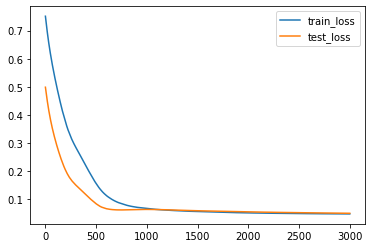

In [8]:
plt.plot(training_history)
plt.plot(testing_history)
plt.legend(['train_loss','test_loss'])

Now that I've trained the model what I wanna do is predict the 1001 observation
This means that we have to use the last possible window in the training data 
to predict the first observation in the test data
this is because this is exactly where the split starts since we split it 1000 and 1000 for both train and test
so we wanna predict the 1001 observation, basically the first observation in our test set
then we can compare and see if they are similar.

In [9]:
# first observation in the test set, we technically "don't know " it 
real_answer=testing_data[0]
## Using the last possible window in the training set, which will be used to predict the next 
#observation
## agian, the next observation is technically "unknown to us" but it is located in the test set.
predict_with_this=training_data[-5:]
predict_with_this=torch.from_numpy(np.array(predict_with_this).astype(np.float32))
predict_with_this=predict_with_this.reshape(1,5,2)
print(predict_with_this,predict_with_this.shape)
model_prediction_observation1001=model_lstm(predict_with_this.to(device))
print("The real vector is ",real_answer, "Our model predicts ",model_prediction_observation1001.cpu())

tensor([[[ 1.1897, -0.1796],
         [ 0.8542, -0.4117],
         [ 1.3834,  0.2082],
         [ 0.9808, -0.0564],
         [ 1.1625,  0.2327]]]) torch.Size([1, 5, 2])
The real vector is  [1.21469097 0.44118558] Our model predicts  tensor([[1.0899, 0.2276]], grad_fn=<ToCopyBackward0>)


Goes to show how hard it is to predict the future when we have not "learned" it. Still kind of close I guess.

Using an LSTM Model to predict the last 1000 unobserved_state_vector- X
Using the first 1000 for training.
For the prediction, I will use the last sliding window, or the last 5 elements of the training_data to predict, and then
slowly but surely, the predictions will be based off of the previous predictions, and not the test data!

Setting up the model:

In [10]:
model_4c=LSTM(n_inputs=D,n_hidden=2,n_outputs=2)
model_4c.to(device)

LSTM(
  (lstm): LSTM(2, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)

This time we have to use the unobserved_state_vector data

Setting up train and test:
also again, I will only be using X for predicting the next X in the training.

In [11]:
input_vector_to_lstm_4c=unobserved_state_vector
X_training_data_X=input_vector_to_lstm_4c[:1000]
X_testing_data_X=input_vector_to_lstm_4c[1000:]

In [12]:
#### 
X_training,y_training=create_timeseries_data(X_training_data_X,5) #<--- first 1000 data points of the unobserved state vector X
X_testing,y_testing=create_timeseries_data(X_testing_data_X,5) # <--- last 1000 data points of the unobserved state vector X
# let's see some examples:
X_training[5] , y_training[5], X_training[6]

([array([0.88382327, 0.49411196]),
  array([0.83365908, 0.58369475]),
  array([0.76443655, 0.65746056]),
  array([0.70198278, 0.73773272]),
  array([0.61608254, 0.79562484])],
 array([0.51326358, 0.83307665]),
 [array([0.83365908, 0.58369475]),
  array([0.76443655, 0.65746056]),
  array([0.70198278, 0.73773272]),
  array([0.61608254, 0.79562484]),
  array([0.51326358, 0.83307665])])

Same process as before... moving to PyTorch World...

In [13]:
###  moving to PyTorch World:
X_train_lstm_4c=torch.from_numpy(np.array(X_training).astype(np.float32))
y_train_lstm_4c=torch.from_numpy(np.array(y_training).astype(np.float32))
X_test_lstm_4c=torch.from_numpy(np.array(X_testing).astype(np.float32))
y_test_lstm_4c=torch.from_numpy(np.array(y_testing).astype(np.float32))
#### Setting up variables
# T for timestep or "window size"s,D number of features and N obviously number of samples
N,T,D=X_train_lstm_4c.shape[0],X_train_lstm_4c.shape[1],X_train_lstm_4c.shape[2]

In [14]:
Train_HIST,Test_HIST=training_function(model=model_4c,X_train=X_train_lstm_4c.to(device)
                                           ,y_train=y_train_lstm_4c.to(device)
                                           ,X_test=X_test_lstm_4c.to(device)
                                           ,y_test=y_test_lstm_4c.to(device))

epoch 0
epoch 300
epoch 600
epoch 900
epoch 1200
epoch 1500
epoch 1800
epoch 2100
epoch 2400
epoch 2700
epoch 3000


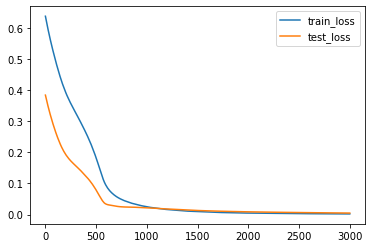

In [15]:
plt.plot(Train_HIST)
plt.plot(Test_HIST)
plt.legend(['train_loss','test_loss'])

Now again, to predict into the future
First I will take the last 5 elements in the X_training_data_X to make predictions and then the next will be based off 
the previous predictions

In [16]:
window=X_training_data_X[-5:]
window=torch.from_numpy(np.array(window).astype(np.float32)).to(device)
#window=window.reshape(1,5,2).to(device)
## making sure window's shape is good to be input-ed into the model.
print("window shape :",window.shape)
## moving window to device
window.to(device)

window shape : torch.Size([5, 2])


tensor([[ 0.4888, -0.8021],
        [ 0.5743, -0.7415],
        [ 0.6375, -0.6884],
        [ 0.7168, -0.6076],
        [ 0.7622, -0.5446]], device='cuda:0')

In [17]:
# list of predictions
preds_list=[]
## running for 1000 iterations, basically trying to predict the last 1000 values 
# for the unobserved_state_vector X
for i in range(1000):
    # making sure input is in correct shape
    to_model_input=window.reshape(1,5,2)
    #inputting the correct shape into the model
    temp_pred=model_4c(to_model_input)
    ## Creating a temp row, this is because we have to take the values 
    ## out item by item.
    temp_row=[temp_pred[0,0].item(),temp_pred[0,1].item()]
    ### appending to predictions list
    preds_list.append(temp_row)
    # finally, removing the first element (the oldest time-wise element) in the data
    # from behind, and adding to the front of the current prediction.
    window=torch.cat((window[1:],temp_pred))

the predictions list:

In [18]:
len(preds_list)

1000

In [19]:
preds_list[:5], preds_list[-5:]

([[0.8031201362609863, -0.4143757224082947],
  [0.8471671938896179, -0.3034721612930298],
  [0.8866221904754639, -0.19350215792655945],
  [0.9204134941101074, -0.08558577299118042],
  [0.9457902908325195, 0.016579389572143555]],
 [[0.3455768823623657, -1.0560321807861328],
  [0.4447592794895172, -1.0199060440063477],
  [0.5240143537521362, -0.9590729475021362],
  [0.5876038074493408, -0.8809071779251099],
  [0.6414201259613037, -0.7915951013565063]])

The real data:

In [20]:
X_testing_data_X[:5],X_testing_data_X[-5:]

([array([ 0.82539245, -0.45310897]),
  array([ 0.84924457, -0.38561993]),
  array([ 0.89148689, -0.29082532]),
  array([ 0.92116183, -0.1951578 ]),
  array([ 0.93166465, -0.10645896])],
 [array([ 0.21251539, -0.60996979]),
  array([ 0.27159919, -0.58650867]),
  array([ 0.33116953, -0.55412796]),
  array([ 0.39822577, -0.50492996]),
  array([ 0.45112322, -0.4581758 ])])

Seems like at the start this is pretty close, but the further into the future we go on, 
the worst the predictions become...